# PBMC3k dataset

In [1]:
import os
import subprocess

whoami = subprocess.run("whoami", stdout=subprocess.PIPE)
if (b'jovyan' in whoami.stdout) & (not os.path.isfile("/home/jovyan/data/pbmc3k.h5ad")):
    !sh /home/jovyan/data/pbmc3k.sh

In [64]:
from typing import NamedTuple
import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns

from tools.preferences import kwarg_savefig
from tools.preprocessing import get_quantiles, filter_pipeline
from tools.go import top_degs, get_deg, go_plot

In [3]:
class Config(NamedTuple):
    data: ad.AnnData = sc.read_h5ad("/home/jovyan/data/pbmc3k.h5ad")
    export: str = "/home/jovyan/output/pbmc3k"
    dsname: str = "PBMC3k"
    
conf = Config()
os.makedirs(conf.export, exist_ok=True)

In [4]:
sc.pp.filter_cells(conf.data, min_genes=200)
sc.pp.filter_genes(conf.data, min_cells=3)
conf.data.uns["dsname"] = conf.dsname

In [5]:
conf.data

AnnData object with n_obs × n_vars = 2700 × 13714
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells'
    uns: 'dsname'

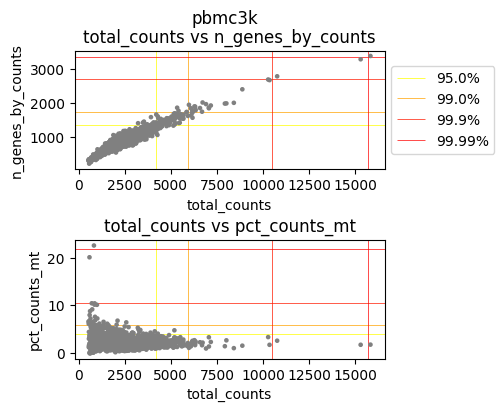

In [6]:
for k, v in {"pbmc3k": conf.data}.items():
    v.var['mt'] = v.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(v, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
    
    fig, ax = plt.subplots(2, 1, figsize=(4, 4))
    plt.subplots_adjust(hspace=.6)

    for a, y in zip(ax, ["n_genes_by_counts", "pct_counts_mt"]):
        sc.pl.scatter(v, x="total_counts", y=y, ax=a, show=False)
        area = [.95, .99, .999, .9999]
        xlims, ylims = a.get_xlim(), a.get_ylim()
        for xval, yval, q in zip(
            get_quantiles(v, "total_counts", area=area),
            get_quantiles(v, y, area=area),
            area
        ):
            kwargs = dict(
                zorder=-1, linewidth=.5, 
                color=plt.cm.autumn_r(q ** 100)
            )
            a.vlines(xval, *ylims, **kwargs)
            a.hlines(yval, *xlims, label=f"{100 * q}%", **kwargs)
        if y == "n_genes_by_counts":
            a.legend(loc="center left", bbox_to_anchor=(1, .5))
        a.set_title(f"total_counts vs {y}")
        a.set(xlim=xlims, ylim=ylims)
        

    fig.suptitle(
        k,
        verticalalignment="center",
        y=.96
    );

In [7]:
filter_dict = {
    "n_genes_by_counts": lambda x: x < 2500,
    "pct_counts_mt": lambda x: x < 10
}

In [8]:
conf = Config(data=filter_pipeline(conf.data, filter_dict))

In [9]:
sc.pp.normalize_total(conf.data, target_sum=1e6)
sc.pp.log1p(conf.data, base=2)

/opt/conda/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


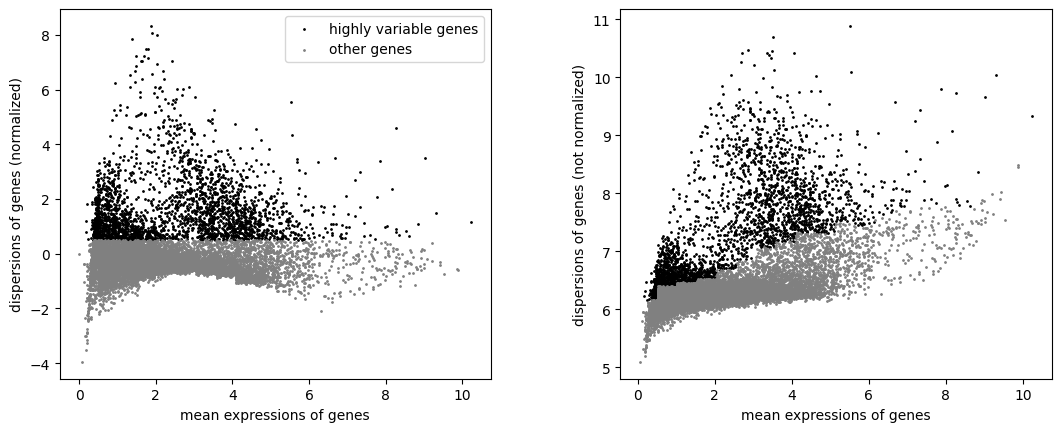

In [10]:
sc.pp.highly_variable_genes(conf.data, min_mean=0.0125, max_mean=15, min_disp=0.5)
sc.pl.highly_variable_genes(conf.data)

In [11]:
sc.tl.pca(conf.data, svd_solver='arpack')

In [12]:
sc.pp.neighbors(conf.data, n_pcs=50)

In [13]:
sc.tl.umap(conf.data)

/opt/conda/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


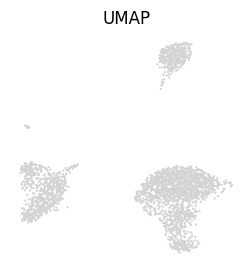

In [14]:
fig, ax = plt.subplots(figsize=(3, 3))

sc.pl.umap(conf.data, ax=ax, size=10, show=False)
ax.axis("off");
ax.set(title=f"UMAP", xlabel="UMAP1", ylabel="UMAP2");

In [15]:
sc.tl.leiden(conf.data, resolution=1)

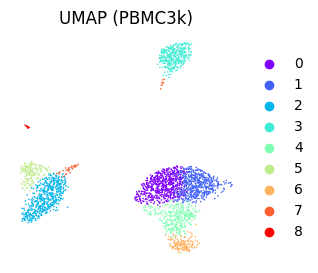

In [109]:
fig, ax = plt.subplots(figsize=(3, 3))

sc.pl.umap(conf.data, color="leiden", ax=ax, size=5, show=False, palette="rainbow")
ax.axis("off");
ax.set(title=f"UMAP ({conf.dsname})", xlabel="UMAP1", ylabel="UMAP2");

fig.savefig(f"{conf.export}/umap.png", **kwarg_savefig)

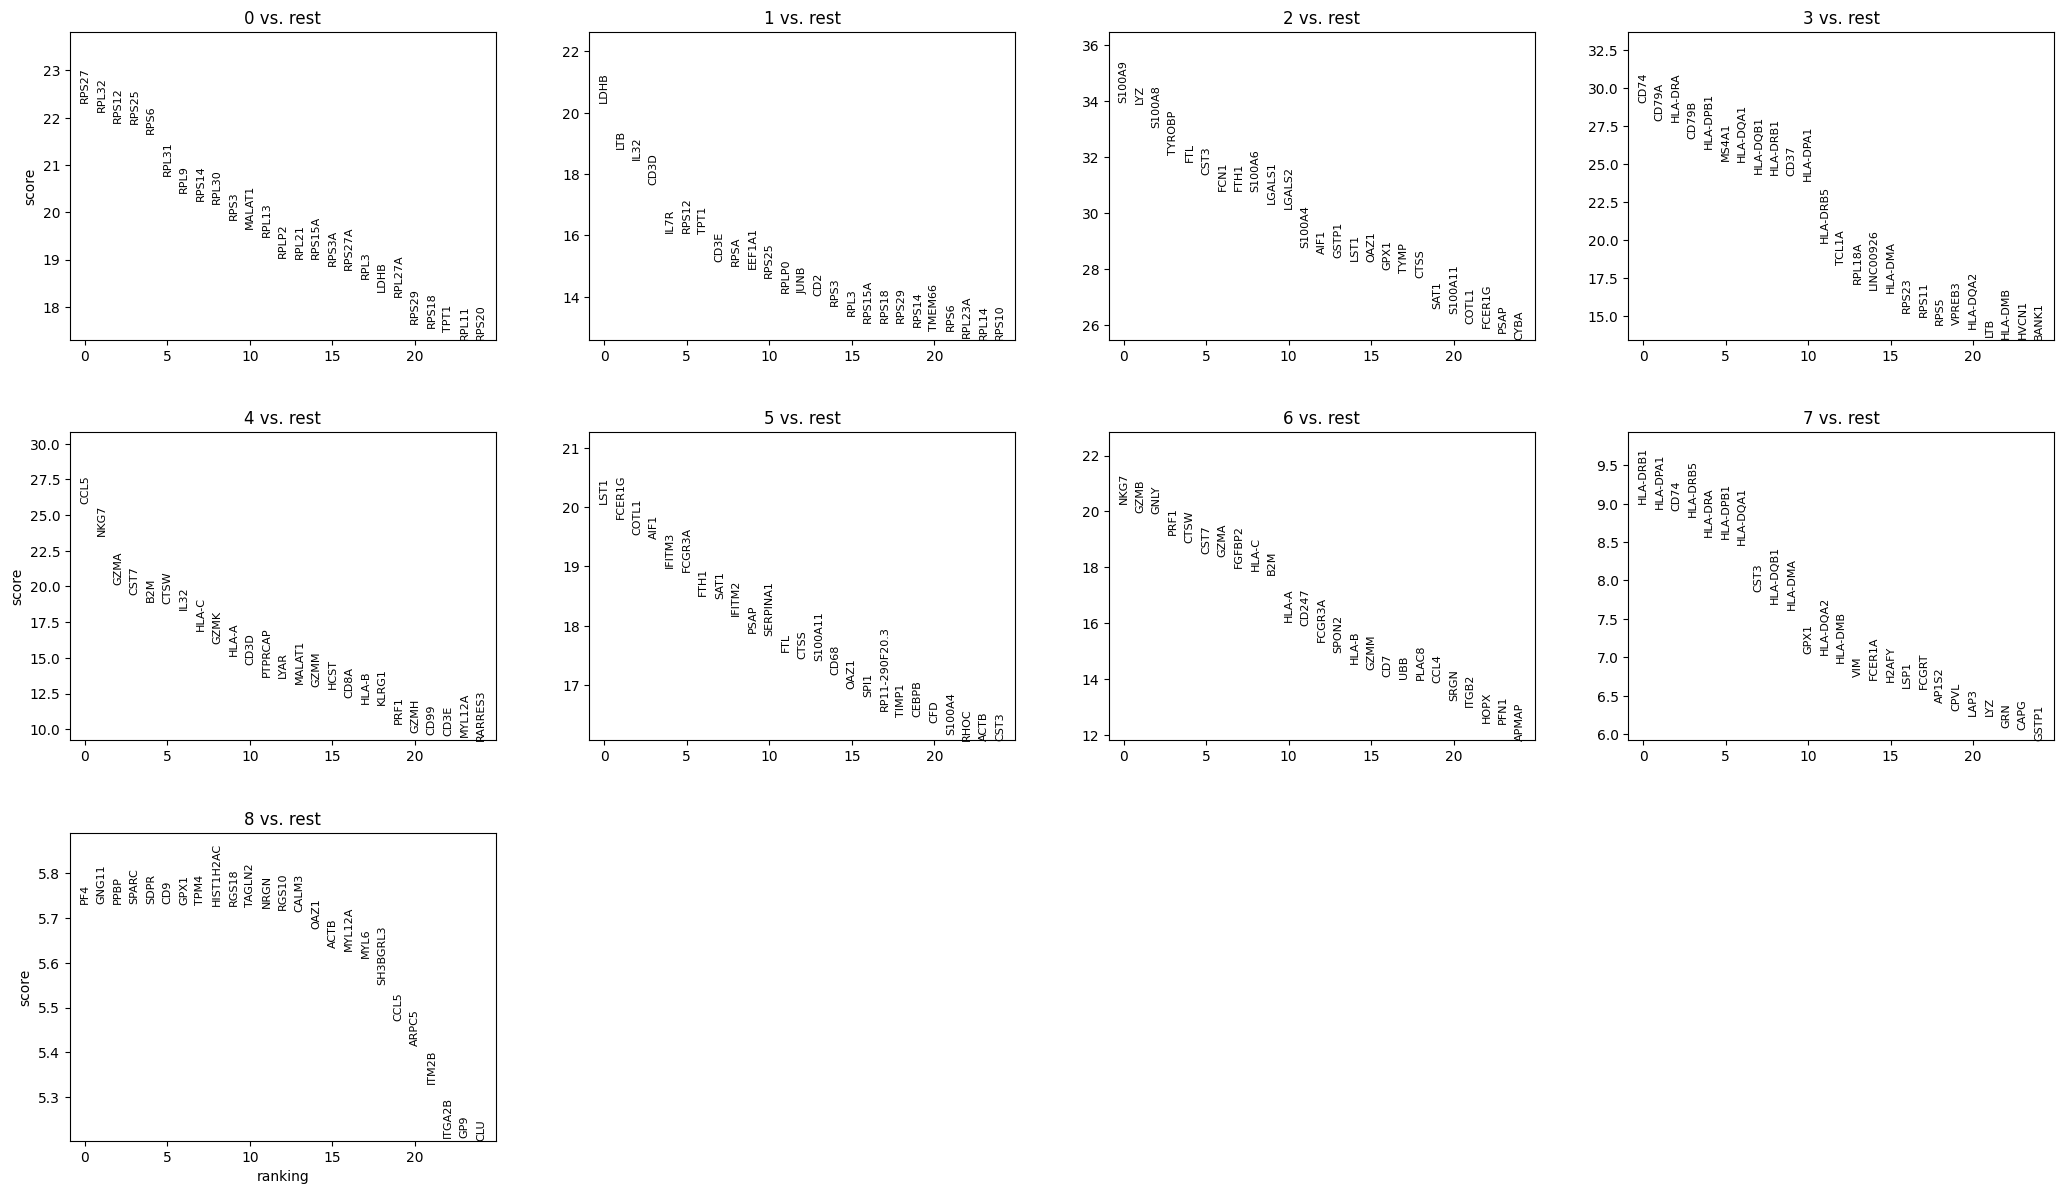

In [17]:
sc.tl.rank_genes_groups(conf.data, "leiden", method='wilcoxon')
sc.pl.rank_genes_groups(conf.data, n_genes=25, sharey=False)

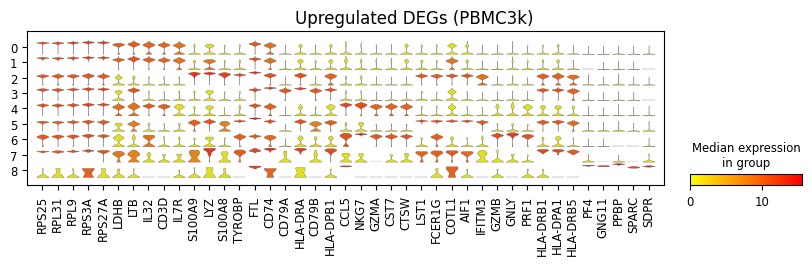

In [116]:
n = 5

fig, ax = plt.subplots(figsize=(10, 2))
sc.pl.stacked_violin(
    conf.data, top_degs(conf.data, n, min_logfc=1),
    groupby="leiden", cmap="autumn_r", 
    ax=ax, show=False, figsize=(10, 2)
)
ax.set_title(f"Upregulated DEGs ({conf.dsname})")

fig.savefig(
    f"{conf.export}/sigup_violin.png",
    **kwarg_savefig
)

for k in conf.data.uns["rank_genes_groups"]["names"].dtype.names:
    if get_deg(conf.data, k, min_logfc=1).size != 0:
        fig, ax = plt.subplots(figsize=(2, 5))
        go_plot(conf.data, cluster_name=k, min_logfc=1, top=30, ax=ax, palette="autumn_r")
        ax.set_title(f"Up. GO terms for {k}", loc="right")

In [143]:
from grnet.clusters import CellClasses
from grnet.models import PC, PretrainedModel
from grnet.plot import grnplot, planetplot

In [24]:
lst_data = [
    [
        conf.data[
            conf.data.obs["leiden"] == cluster_id,
            get_deg(conf.data, name, pvals_adj=p, min_logfc=1)[:5]
        ] for cluster_id in conf.data.uns["rank_genes_groups"]["names"].dtype.names
    ] for name in conf.data.uns["rank_genes_groups"]["names"].dtype.names
]

In [35]:
import warnings
warnings.filterwarnings("ignore")

In [36]:
models = [
    PC(lst_data[i // 9][i % 9].to_df()) for i in range(9 ** 2)
]

for m in models:
    m.estimate()

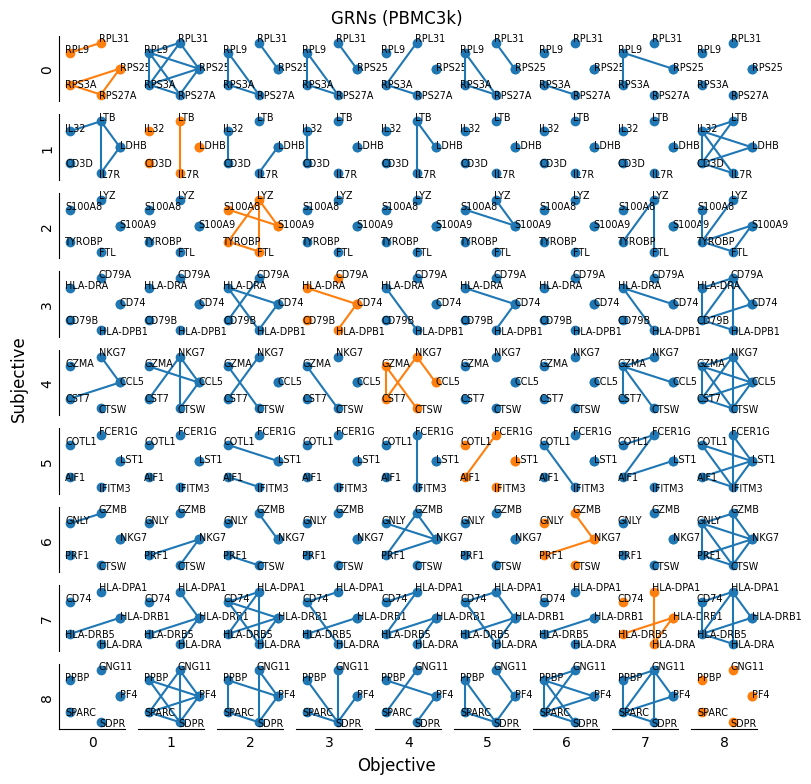

In [110]:
fig, ax = plt.subplots(9, 9, figsize=(9, 9))

for (i, m), a in zip(enumerate(models), ax.ravel()):
    grnplot(m, ax=a, color="C1" if i // 9 == i % 9 else "C0")
    names = conf.data.uns["rank_genes_groups"]["names"].dtype.names
    a.spines['left'].set_visible(i % 9 == 0)
    a.spines['bottom'].set_visible(i // 9 == 8)
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.tick_params(
        axis='both', which='both', 
        bottom=False, top=False, left=False, right=False, 
        labelbottom=False, labelleft=False
    )
    a.axis("on") if (i // 9 == 8) | (i % 9 == 0) else None
    a.set(
        xlabel=names[i % 9] if i // 9 == 8 else "",
        ylabel=names[i // 9] if i % 9 == 0 else ""
    )
fig.supylabel("Subjective", x=.07)
fig.supxlabel("Objective", y=.06)
fig.suptitle(f"GRNs ({conf.dsname})", y=.91)

fig.savefig(f"{conf.export}/grns.png", **kwarg_savefig)

In [62]:
from grnet.evaluations import d_asterisk

In [68]:
metric_matrix = pd.DataFrame(
    np.array(
        [d_asterisk(
            models[9 * (i // 9) + (i // 9)].get_matrix(), 
            models[i].get_matrix()
        ) for i in range(9 ** 2)]
    ).reshape(9, 9),
    index=conf.data.uns["rank_genes_groups"]["names"].dtype.names,
    columns=conf.data.uns["rank_genes_groups"]["names"].dtype.names
)

In [70]:
import seaborn as sns

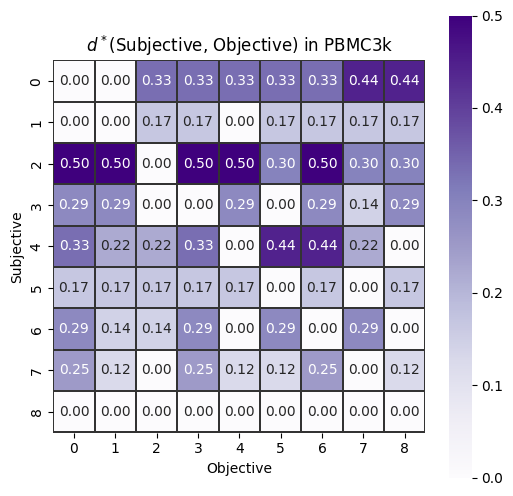

In [111]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(
    data=metric_matrix,
    square=True, vmin=0,
    annot=True, fmt=".2f",
    cmap="Purples", ax=ax,
    linewidth=.1, linecolor=".2"
)

ax.set(
    ylabel="Subjective", 
    xlabel="Objective", 
    title="$d^*$" + "(Subjective, Objective)" + f" in {conf.dsname}"
);

fig.savefig(f"{conf.export}/dasterisk.png", **kwarg_savefig)

In [123]:
new_datalist = [
    conf.data[
        conf.data.obs["leiden"] == cluster_id,
        get_deg(conf.data, "8", pvals_adj=p, min_logfc=1)[:10]
    ] for cluster_id in conf.data.uns["rank_genes_groups"]["names"].dtype.names
]

new_models = [
    PC(new_datalist[i].to_df()) for i in range(9)
]

for m in new_models:
    m.estimate()

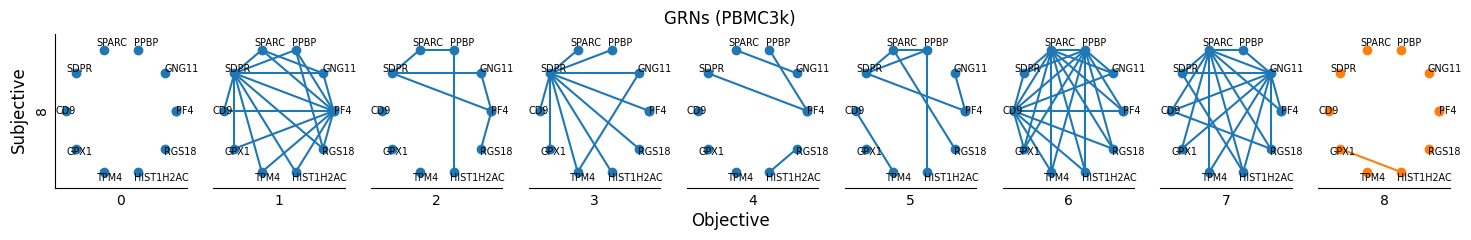

In [140]:
fig, ax = plt.subplots(1, 9, figsize=(18, 2))

for (i, m), a in zip(enumerate(new_models), ax.ravel()):
    grnplot(m, ax=a, color="C1" if i == 8 else "C0")
    names = conf.data.uns["rank_genes_groups"]["names"].dtype.names
    a.spines['left'].set_visible(i % 9 == 0)
    a.spines['bottom'].set_visible(True)
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.tick_params(
        axis='both', which='both', 
        bottom=False, top=False, left=False, right=False, 
        labelbottom=False, labelleft=False
    )
    a.axis("on")
    a.set(
        xlabel=names[i % 9],
        ylabel=8 if i % 9 == 0 else ""
    )
fig.supylabel("Subjective", x=.1)
fig.supxlabel("Objective", y=-.1)
fig.suptitle(f"GRNs ({conf.dsname})", y=1)

# fig.savefig(f"{conf.export}/grns_for_8.png", **kwarg_savefig)

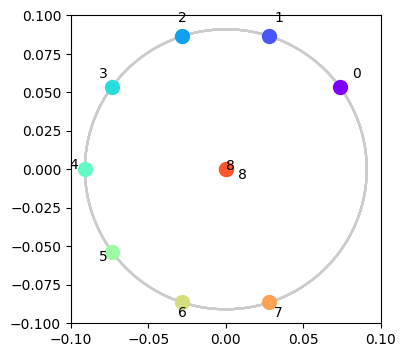

In [147]:
newds = CellClasses(
    models=new_models,
    colors="rainbow"
)

planetplot(subjective=newds, objective=newds, id=8, s=100)

In [142]:
newds

In [118]:
new_models = [
    get_deg(conf.data, "8", pvals_adj=p, min_logfc=1)[:10]

array(['PF4', 'GNG11', 'PPBP', 'SPARC', 'SDPR', 'CD9', 'GPX1', 'TPM4',
       'HIST1H2AC', 'RGS18'], dtype=object)

In [61]:
models[0].get_matrix()

,RPS25,RPL31,RPL9,RPS3A,RPS27A
RPS25,1.0,0.0,0.0,1.0,1.0
RPL31,0.0,1.0,1.0,0.0,0.0
RPL9,0.0,0.0,1.0,0.0,0.0
RPS3A,0.0,0.0,0.0,1.0,1.0
RPS27A,0.0,0.0,0.0,0.0,1.0


In [37]:
[conf.data[name for name in conf.data.uns["rank_genes_groups"]["names"].dtype.names]

['0', '1', '2', '3', '4', '5', '6', '7', '8']

In [46]:
top_degs(conf.data, 5, pvals_adj=p, min_logfc=1)

array(['RPS25', 'RPL31', 'RPL9', 'RPS3A', 'RPS27A', 'LDHB', 'LTB', 'IL32',
       'CD3D', 'IL7R', 'S100A9', 'LYZ', 'S100A8', 'TYROBP', 'FTL', 'CD74',
       'CD79A', 'HLA-DRA', 'CD79B', 'HLA-DPB1', 'CCL5', 'NKG7', 'GZMA',
       'CST7', 'CTSW', 'LST1', 'FCER1G', 'COTL1', 'AIF1', 'IFITM3',
       'GZMB', 'GNLY', 'PRF1', 'HLA-DRB1', 'HLA-DPA1', 'HLA-DRB5', 'PF4',
       'GNG11', 'PPBP', 'SPARC', 'SDPR'], dtype=object)

In [34]:
get_deg(conf.data, "0", pvals_adj=p, min_logfc=1)[:5]

array(['RPS25', 'RPL31', 'RPL9', 'RPS3A', 'RPS27A'], dtype=object)

In [6]:
import grnet

In [6]:
import subprocess

In [13]:
hoge = subprocess.run("whoami", stdout=subprocess.PIPE)

In [36]:
hoge.stdout == b'jovyan\n'

True

In [37]:
hoge.stdout

b'jovyan\n'

In [39]:
b'jovyan' in b'jovyan\n'

True